Acquisition and Analysis of Neural Data 

Exercise 04

Bramantyo Ibrahim Supriyatno

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.linalg import eig

import seaborn as sns
import scipy.io
import time

sns.set(style="darkgrid", context="talk", palette="pastel")
plt.style.use('seaborn')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/pythonscripts')

ModuleNotFoundError: No module named 'google'

In [2]:
fn = '/content/drive/My Drive/dataset/c1p8.mat'


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/dataset/c1p8.mat'

In [3]:
fn = 'c1p8.mat'

In [6]:

mat_data = scipy.io.loadmat(fn)
rho = mat_data['rho'].ravel() 
stim = mat_data['stim'].ravel()

In [7]:
del_t = 2e-3
max_t = 20*60
sr = 1./del_t
max_tau = 0.3
max_tau_n_samples = max_tau / del_t
num_spikes = np.sum(rho)

# 1. Spike-triggered Average

In [8]:
def compute_sta(spike_train, stimulus, max_tau, del_t):
    
    num_samples = int(max_tau/del_t)
    taus = np.arange(0, num_samples, step=1)
    sta = np.zeros_like(taus)
    
    num_trial = spike_train.shape[0]
    spike_idx = np.where(spike_train == 1)[0]
    spike_idx = spike_idx[spike_idx >= taus[-1]]

    num_spikes = spike_idx.shape[0]

    for tau in taus:
        idx_del = spike_idx - tau         
        stim = stimulus[idx_del]

        sta[tau] = np.sum(stim)
    
    return sta/num_spikes

In [9]:
start = time.time()
sta1 = np.correlate(rho, stim, 'same')/num_spikes
end = time.time()
print('time elapsed (np.correlate): {}'.format(end - start))
start = time.time()
sta2 = compute_sta(rho, stim, max_tau, del_t)
end = time.time()
print('time elapsed (iteration): {}'.format(end - start))

In [ ]:
mid = int(sta1.shape[0]/2)
ticks = np.arange(300, -50, -50)
t = np.linspace(0,int(max_tau/del_t),len(ticks))

plt.plot(mp.flip(sta1[mid-150:mid]) + 0.25*np.max(sta1), label='np.correlate (offset)')
plt.plot(np.flip(sta2), label='iteration ')

plt.title('STA')
plt.ylabel('degrees per second')
plt.xlabel('time (mS)')
plt.xticks(t, ticks)
plt.legend()

plt.show()

Discussion:

Since the data is 6 minutes long, taking correlation would not waste computational time since it would multiply all stimulus samples with each spike. 

# 2. Linear encoding kernel D

5.10733715736814


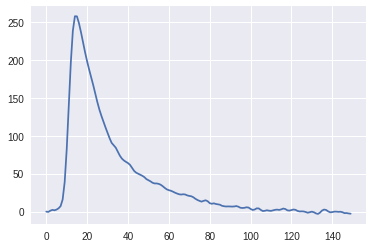

In [ ]:
rate = num_spikes / max_t
var = np.var(stim)*del_t

d_kernel = sta2 * rate / var
print(var)
plt.plot(d_kernel)

# 3. Predicting the Neuron's Response

In [ ]:
def get_r_est(r0, kernel, stimulus, del_t):
  return r0 + np.convolve(stimulus, kernel) * del_t

In [ ]:
def get_rect_kernel(width, del_t):

  width_i = int(width / del_t) 
  rect_kernel =  np.full(width_i, 1/width)
  return rect_kernel

In [ ]:
rect_kernel = get_rect_kernel(0.02, del_t)

In [ ]:
r0 = rate + 1.1243933488842945
d_r_est = get_r_est(r0, d_kernel, stim, del_t)
r_r_est = np.convolve(rect_kernel, rho)

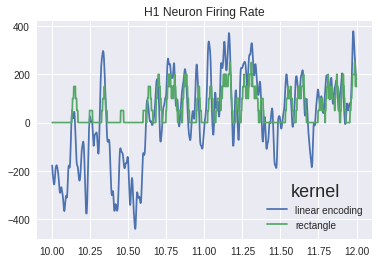

In [ ]:
start_n = int(10*sr) 
stop_n = int(12*sr)

t = np.linspace(10,12, stop_n-start_n)

plt.plot(t, d_r_est[start_n:stop_n], label='linear encoding')
plt.plot(t, r_r_est[start_n:stop_n], label='rectangle')
plt.legend(title='kernel')
plt.title('H1 Neuron Firing Rate')
plt.show()

In [ ]:
d_r_est.mean()

44.66749999999999

Discussion:

In general estimated rate can predict the firing rate of neurons given its stimulus. The graph also matches the rectangular sliding firing rate. One caveat is that the estimation returns negative firing rate. This can be mitigated by applying activation function such as sigmoid.